<center><h1> Solving Maximum Clique with QAOA </h1></center>
<center><h3> by Bernardo Oviedo and Charles Goode </h3></center>

### Introduction
In graph theory, a clique is defined as a set of vertices such that every vertex in the set is connected to every other vertex in the set. The maximum clique of a graph is defined as the clique of greatest magnitude in the graph. Deciding a clique requires checking whether two nodes share an edge $n-1$ times for each of $n$ nodes in a given set. There are $2^N$ sets to check in a graph of $N$ total nodes when determining maximum clique.
<p>
The Quantum Approximate Optimization Algorithm is an quantum algorithm for approximating the answers to optimization problems. The algorithm is a simplification of the Quantum Adiabatic Algorithm, breaking up the ground state transition process into very coarse jumps in energy state. In general, this involves making rotations governed by the encoded cost function on a multiqubit plus state. This ideally encodes output of the cost function into the coefficient of each pure state in superposition.</p>

### Methods
To map maximum clique to QAOA, each qubit encodes a node in the graph. For a given bit string in the superposition, each qubit with the value of 1 is in the set being evaluated for maximum clique. Through this encoding, the $2^N$ possible subsets of the set of all nodes in the graph are captured by the superposition of the qubits.
<p>To evaluate each potential set, the cost Hamiltonian is a sum of two types of local constraints and the driver Hamiltonian is Pauli X on each input qubit.</p>
\begin{align*}
\boldsymbol{V}(\gamma) &= e^{-i\gamma \boldsymbol{C}} & C &=\sum_{i, j \in N}{C_{m}} \quad & C_{m} =
  \begin{cases} 
      \frac{1}{2} (I - C^{Z}_{ij}) & (i, j) \in E\\
      -\frac{n}{2} (I - C^{Z}_{ij}) &  (i, j) \notin E\\
   \end{cases}\\
\boldsymbol{W}(\beta) &= e^{-i\beta \boldsymbol{B}}
& B &= \sum_{k=1}^{N}{X_k}\\
\end{align*}
where $n$ is a penalty constant necessary to devalue incorrect solutions appropriately. In experimentation, we used a $n$ value of $\frac{N(N-1)}{2}$, the maximum number of edges in a graph of $N$ nodes. This is upper bound ensures the correct solution has the highest cost. If a set collected a cost equal to the maximum clique but also included nodes without necessary connection to the rest, this penalty will ensure the cost of that state is non-positive. The highest possible cost of the maximum clique would be in the case of a complete graph which would accrue a cost equal to the maximum number edges.
<p>We chose to optimize $\gamma$ and $\beta$ by gradient ascent, alternating steps in $\gamma$ and $\beta$ with step size $\eta = 0.1$ until the average of $|\Delta\gamma|$ and $|\Delta\beta|$ reached at most $0.05$. $$\Delta\gamma = \frac{F(\gamma + \eta,\beta) - F(\gamma - \eta, \beta)}{2\eta} $$ The starting value was chosen arbitrarily to be $\gamma = \beta = 2$</p> 

### Results and Discussion
Through gradient ascent, we reached a maximum at $\gamma = 4.6015625$ and $\beta = 0.18702062766020688$, which took 60 steps total.
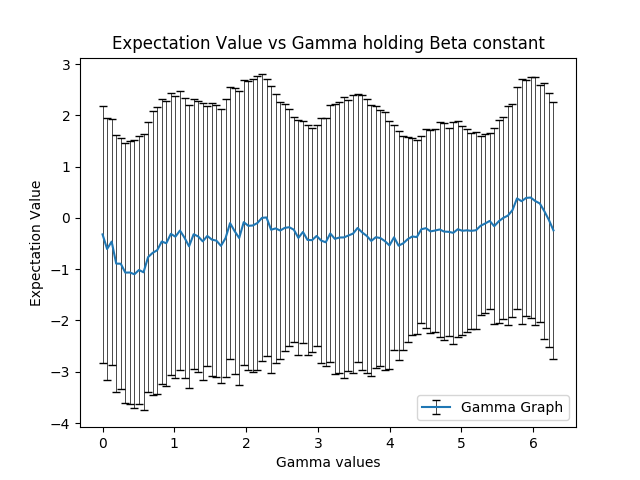 
This graph shows how the expectation value of the cost changes with respect to gamma while holding beta fixed to the value found through optimization. The error bars come from the sample standard deviation calculated at the end of the algorithm for each run. 
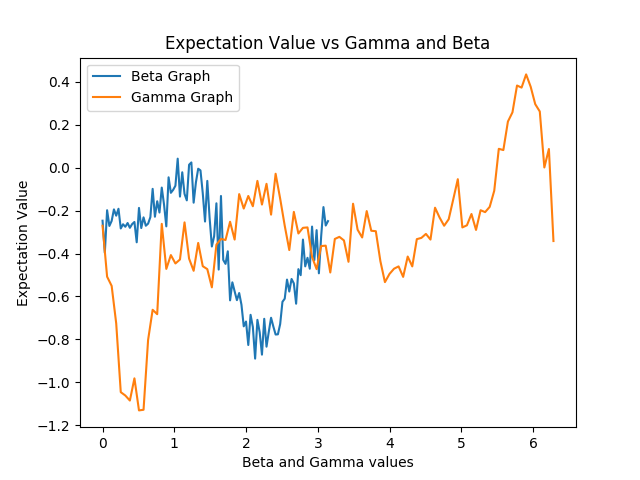
This graph shows how the expectation value varies for both beta and gamma while holding the other constant to its optimized value. 

The following graphs are runs from the algorithm on several random graphs. The x-axis is the ratio of an output state's cost to the cost of the classically computed maximum cost given the same graph. The y-axis is the numbers counts for a given state's x value.

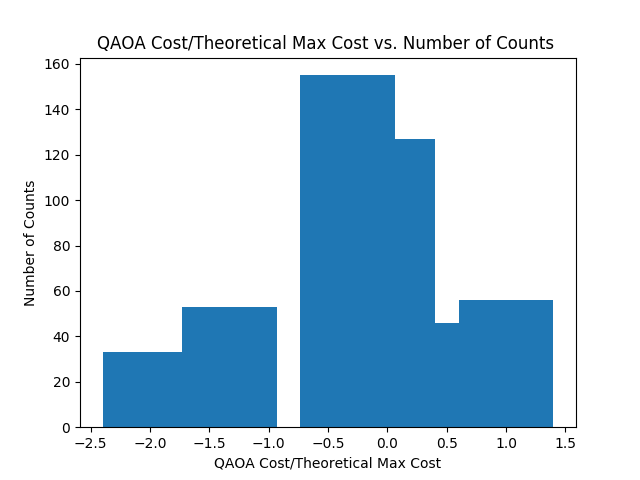
This graph was a graph with 4 nodes

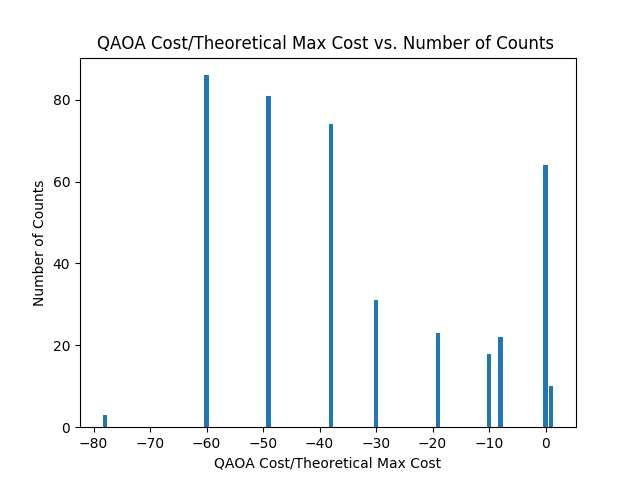
This graph was a graph with 5 nodes

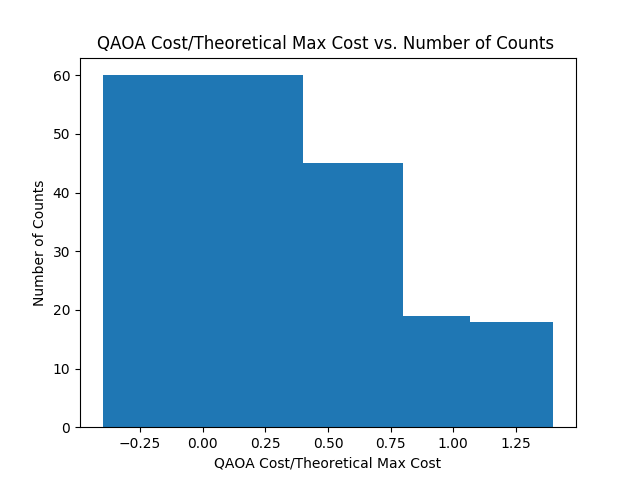
This graph was a graph with 6 nodes

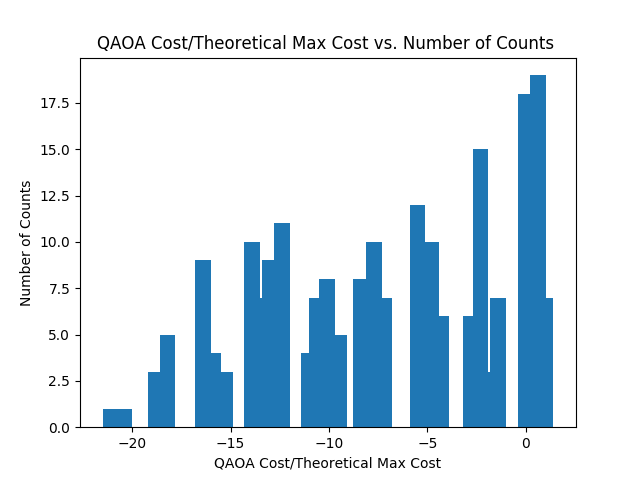
This graph was a graph with 8 nodes

### Conclusion
Run with enough shots, the algorithm always finds the correct solution. The expectation value on the other hand is not very accurate with respect to the optimal solution; for the optimized gamma and beta values the corresponding maximized expectation value was -0.3115234375, 110% of the ideal cost of 3 for the test graph. This is because of the lazy penalization technique. With further pure math exploration of the problem or experimental tuning of the penalty, the expectation value could highly improve. Although the expectation value of the state reached by the alhis method seems reliable for getting the answer


### Our Code
###### Help code

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import json
from graph import *

In [2]:
def makeCircuit(inbits, outbits):
    q = qiskit.QuantumRegister(inbits+outbits)
    c = qiskit.ClassicalRegister(inbits+outbits)
    qc = qiskit.QuantumCircuit(q, c)

    q_input = [q[i] for i in range(outbits,outbits+inbits)] 
    q_output = [q[j] for j in range(outbits)]

    return qc, c, q_input, q_output

# measure all qubits in q_input register, return dictionary of samples
def measureInput(qc, q_input, c):
    for i in range(len(q_input)):
        qc.measure(q_input[i], c[i])
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=1024)
    return job.result().get_counts(qc)

### The Algorithm
It takes gamma and beta and the graph to evaluate and returns the expectation value of the cost function. It should be noted here that this is not the same as the expectation value of the maximum clique although max clique is related to cost. For $\max C$ the clique size is the positive, real root of $n-n-2C$ since $C = E$ where $E$ is the number of edges in the maximum clique. Due to the penalty value being decently large, the expectation of the cost is rarely a positive value so the roots are imaginary and meaningless.

In [3]:
###The Algorithm
def applyQAOA(gamma, beta, graph):
    ### INIT REGS
    qc, c, q_input, q_output = makeCircuit(graph.getNumNodes(), 1);
    PENALTY = graph.getMaxEdges()
    ### H on every input register
    for node in q_input:
        qc.h(node)
    complement = graph.getEdgesComp();
    edges = graph.getEdges()
    ### APPLY V AND W
    ### APPLY V
    # EDGES IN THE GRAPH
    for edge in edges:
        nodeList = edge.getNodes()
        qc.cu1(-gamma, q_input[nodeList[0].name], q_input[nodeList[1].name])
        # EDGES NOT IN THE GRAPH
        for edge in complement:
            nodeList = edge.getNodes()
            qc.cu1(PENALTY*gamma, q_input[nodeList[0].name], q_input[nodeList[1].name])
                    
    ### APPLY W
    for node in q_input:
        qc.h(node)
        qc.u1(2*beta, node)
        qc.h(node)

    ### Measure
    results = measureInput(qc, q_input, c)
    ### Compute the result expectation
    

    ### Parse the result list.
    # B/c we only care about counts associated with input register
    # we combine the counts of states with same input register bits
    
    counts = dict()
    for key in results:
        if key[1:] not in counts:
            counts[key[1:]] = results[key]
        else:
            counts[key[1:]] += results[key] 

    
    #print(counts)
    eox = 0
    #eox2 = 0

    for val in counts:
        cliqNum = 0
        for edge in edges:
            nodeList = edge.getNodes()
            #print("Node 1:", nodeList[0].name,"Node 2:", nodeList[1].name)
            if val[nodeList[0].name] == '1' and val[nodeList[1].name] == '1':
                cliqNum += 1
        for edge in complement:
            nodeList = edge.getNodes()
            if val[nodeList[0].name] == '1' and val[nodeList[1].name] == '1':
                cliqNum -= PENALTY
        eox += counts[val]/1024 * cliqNum
        #eox2 += (cliqNum**2) * counts[val]/1024
    #std = np.sqrt((len(counts)/(len(counts) -1))*(eox2 - eox**2))
    return eox#, std

### The optimizer code
It was difficult to get this to ever terminate in a tolerable amount of time. This starting position and corresponding parameters passed where the one of the only ones that did finish. 

In [4]:
### gradient ascent optimizer
# graph is graph to optimize over
# epsilon controls how far out the delta is calculated
# eta is learning rate
# threshold is the average of gamma and beta that we will consider a max

def optimize(graph, epsilon, eta, threshold):
    count = 0
    gamma = 2
    beta = 2
    dgamma = (applyQAOA(gamma + epsilon, beta, graph) - applyQAOA(gamma - epsilon, beta, graph))/(2*epsilon)
    dbeta = (applyQAOA(gamma, beta + epsilon, graph) - applyQAOA(gamma, beta + epsilon, graph))/(2*epsilon)
    flipper = True #Alternate between maxing gamma and maxing beta
    while((abs(dgamma) + abs(dbeta))/2 > threshold):
        if(flipper):
            if (dgamma > 0): 
                gamma = (gamma + (dgamma * eta)) % (2*np.pi)
            elif (dgamma < 0):
                gamma = (gamma - (dgamma * eta)) % (2*np.pi)
            dgamma = (applyQAOA(gamma + epsilon, beta, graph) - applyQAOA(gamma - epsilon, beta, graph))/(2*epsilon)
        else:
            if(dbeta > 0):
                beta = (beta + (dbeta * eta)) % np.pi
            elif (dbeta < 0):
                beta = (beta - (dbeta * eta)) % np.pi
            dbeta = (applyQAOA(gamma, beta + epsilon, graph) - applyQAOA(gamma, beta + epsilon, graph))/(2*epsilon)
            
        count+=1
        print("Count", count, "dg", dgamma, "db", dbeta)
        flipper = not flipper
    
    print(count)
    return gamma, beta

### Main
We have a lot of commented out code here that collected data for the report. Not sure if all of the JSON file stuff will work on someone else's computer.

In [8]:
def main():
    
    ###TESTING GRAPH
    #0---1
    #| / |
    #3---2
    myGraph = Graph(0, 0)
    nodes = [Node(i) for i in range(4)]

    edges = []
    edges.append(Edge(nodes[0], nodes[1]))
    edges.append(Edge(nodes[1], nodes[2]))
    edges.append(Edge(nodes[2], nodes[3]))
    edges.append(Edge(nodes[3], nodes[0]))
    edges.append(Edge(nodes[3], nodes[1]))

    for n in nodes:
        myGraph.addNode(n)
    
    for e in edges:
        myGraph.addEdge(e)

    BestGamma = 4.6015625
    BestBeta = 0.18702062766020688   
    ### Run the algorithm
    expect = applyQAOA(BestGamma, Besteta, myGraph)
    print("Expectation Value:", expect)

    ### OPTIMIZE

    #bestGamma, bestBeta = optimize(myGraph, 0.1, 0.1, 0.05)
    #print("BestGamma: ", bestGamma, "bestBeta", bestBeta)
    #print("Optimized Expectation value", applyQAOA(bestGamma, bestBeta, myGraph))
    #print("Optimal Gamma:", bestGamma, "Optimal Beta:", bestBeta)
    #BestGamma:  4.6015625 bestBeta 0.18702062766020688
    #Optimized Expectation value -0.3115234375

    ### Make graphs.
    # I'm thinking we hold one variable constant at its maxed value
    # and vary the other and vice versa.
    # Gamma has a larger range than beta. Do we want more data points for gamma than beta?
    # The last page of the worksheet says exactly which graphs we need in our report
    # so make sure we have at least those

    
    betas = np.linspace(0, np.pi, 10)
    gammas = np.linspace(0, 2*np.pi, 100)
    varyingBeta = []
    varyingGamma = []
    betaSTD = []
    gammaSTD = []
    
    y = []
    std = []
    
    #for gammaa in gammas:
    #    e, s = applyQAOA(gammaa, BestBeta, myGraph)
    #    y.append(e)
    #   std.append(s)

    with open("varyingGamma.txt", 'w') as f:
        json.dump(y, f)

    with open("gammaSTD.txt", 'w') as f:
        json.dump(std, f)
    """
    y = []
    std = []
    for betaa in betas:
        e, s = applyQAOA(BestGamma, betaa, myGraph)
        y.append(e)
        std.append(s)
        
    with open("varyingBeta.txt", 'w') as f:
        json.dump(y, f)

    with open("betaSTD.txt", 'w') as f:
        json.dump(std, f)
    """   
    with open("varyingGamma.txt", 'r') as f:
        varyingGamma = json.load(f)
    
    #with open("varyingBeta.txt", 'r') as f:
    #   varyingBeta = json.load(f)

    #with open("betaSTD.txt", 'r') as f:
    #    betaSTD = json.load(f)

    with open("gammaSTD.txt", 'r') as f:
        gammaSTD = json.load(f)
    
    #betaG = plt.errorbar(betas, varyingBeta, betaSTD, ecolor='black', elinewidth = 0.5, capsize=3)
    gammaG = plt.errorbar(gammas, varyingGamma, gammaSTD, ecolor='black', elinewidth = 0.5, capsize=3)
    plt.legend(('Gamma Graph',))
    plt.xlabel('Gamma values')
    plt.ylabel('Expectation Value')
    plt.title('Expectation Value vs Gamma holding Beta constant')
    plt.show()

main()


UnboundLocalError: local variable 'BestGamma' referenced before assignment